---
# House Pricing Prediction
---

# Group 20 : Solution
## by Clément Bernard,Brugeres Maxence and Martin Guyard 



The goal of this challenge is to predict the price of a house, knowing few features. 
<br>
We have around 81 features that describe the house. These features are not clean, not all relevant, and sometimes redundant. 
<br>
The train dataset is around 1200 samples and the test dataset around 260.


# 1. Data pre-processing

<br> This section explain how the data have been cleaned by dealing with NaN values and outliers, then encoding categorical features with ordinal encoding or K encoding, and how feature selection has been performed.
<br>



## 1.1 Features selection

### Missing features


First, let's see the top 5 percentage of <b> missing values </b> for the features.
<br>
Indeed, if there are features with too much missing values, there's no interest in keeping them.
    

In [5]:
(dataset.isnull().sum()/dataset.shape[0]*100).sort_values(ascending = False).head(5)

PoolQC         99.666667
MiscFeature    96.083333
Alley          93.750000
Fence          81.083333
FireplaceQu    47.000000
dtype: float64

It will be hard to deal with features that have too much missing values. So, we decided to remove the features that have more than 30 % missing values. Indeed, this choice is arbitrary and aims at having data that is correct and not fulfilled by false ones. 
<br>
<br>
<b>Note :</b> One might think that PoolQC is interresting because it gives an information about weither there is a pool or not, but this information is already contained in the feature PoolArea. 


### Non relevant features


Then, let's see the relation between features and the SalePrice (our target).
<br>
We needed to differentiate the numerical features from the categorical ones (non numeric). 
<br>
For the categorical features, we used mutual information with the SalePrice.


Text(0.5,1,'Mutual information for categorical features')

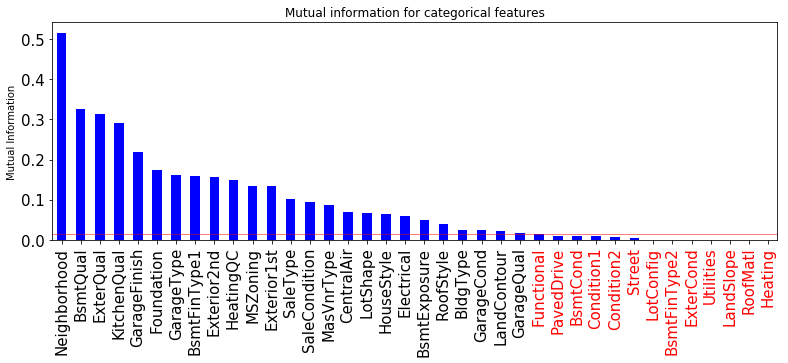

The data has been simplified by dropping the features with a too low mutual information with respect to the SalePrice. The threshold was set to 0.015 in order to only drop the least relevant features (there is a plateau at 0.015 that allows us to choose this threshold). Therefore, not too many features are dropped.

<b> 13 categorical features </b> were dropped  <br>

We applied a similar processing for numerical features using the correlation with the SalePrice. The correlation threshold was set to 0.06 for the same reason. <br>
This way, <b> 8 numerical features </b> were dropped.

### Redundant features


To check if there are some redundant features, the correlation between features could be helpful. Highly correlated features should be dropped because they contain the same information and is can hurt the training of linear models. <br>
Therefore, we made the threshold equal to 0.8. It is an arbitrary threshold that leads to sensible results since the correlated features are indeed dependant. For instance <b> YearBuilt </b> and <b> GarageYearBuilt </b> are often the same value since garages are often built with the house, thus only one should be kept. 

In [20]:
# Print the correlation (higher than 0.8) for correlated features

Feature 1                 Feature 2                 Correlation              
YearBuilt                 GarageYrBlt               0.839                    
TotalBsmtSF               1stFlrSF                  0.807                    
GrLivArea                 TotRmsAbvGrd              0.83                     
GarageCars                GarageArea                0.885                    


We dropped one features in each of these pairs, the one that is less correlated with the SalePrice


## 1.2 Missing values

Now that we have all the features we want to work with, missing values can be dealt with. 
<br>
Some features have <b> missing values</b>. 
<br>
To decide how to replace them, we have differentiated our approach whether the feature is <b> numerical </b> or <b> categorical (non numeric)</b>. 

### Missing values in numerical features



We handled <b> NaN </b>  values by taking the <b>mean</b>. <br>
This is an arbitrary decision. We also could have chosen to do some regression or nearest neighboor to extrapolate the missing values.

### Missing values in categorical features



<b> Nan </b> values in categorical features were replaced by <b> None </b> strings, which will basically add a feature when we'll do K-encoding.





## 1.3 Vectorization of categorical features

Even if missing values are filled, <b> categorical features </b> have to be turned into <b> numerical ones </b> (for the models). 



We had two choices : either to use <b> ordinal encoding </b> (like 'bad' becomes 0, 'good' becomes 1, 'very good' becomes 2, etc) or <b> K-encoding </b> (creation of binary categories).
<br>
On one hand, <b> Ordinal encoding </b> is relevant if the feature represents a hierarchy between its values.
<br>
On the other hand, <b> K-encoding </b> is relevant when there is no hierarchy between the categories of a feature.


### Ordinal encoding 


To know which feature has a natural order, we analysed the categorical feature one by one.  <br>
After an analysis on the data, whenever there is a quality criteria that comes, there is an order and therefore  converting it into integers makes sense. <br>
Let's see with an example : the feature <b> BsmtQual </b>. It has 5 possible values : 'Gd', 'TA', 'Ex', 'None', 'Fa'

This is a feature which evaluates the height of the basement. <br>
If the height is high (100+ inches), the value encoded will be <b> 'Ex' </b> for <b> Excellent </b>. 
This is the same idea for <b>'Ta' : Typical</b> , <b> 'Gd' : Good </b>, etc. <br>
We considered it as an order and therefore we converted it into ordered numbers with the following dictionary : 

   dic_ex = { <b>'Po'</b> : 0, <b>'Fa'</b> : 1, <b>'None'</b> : 2, <b>'TA'</b> : 3, <b>'Gd'</b> : 4, <b>'Ex'</b> : 5}

Note that the <b> None </b> value was before a <b> NaN </b> value, and so we considered it as an average quality (arbitrary choice). <br> The same work has been done on all the ordered categorical features by adapting the dictionnary.

### K-encoding 

For the categorical features that don't have order, we K-encoded them. <br>
Let's see with an example. <br>
The feature <b> MSZoning </b> describes the general zoning of the sale. Its values are 'RL', 'RM', 'C (all)', 'FV' and 'RH'. It can either be <b> Residential High Density (RH) </b>, <b> Commercial (C) </b>, and so on. <br>





There is no order and therefore we created a new feature for each possibility (one for Residential High Density, one for Commercial, etc) with inside binary values (0 or 1).


Here is the result of the <b> K-encoding </b> for the feature <b> MSZoning </b> (we used the 'get_dummies' function)

In [83]:
pd.get_dummies(dataset['MSZoning'], prefix_sep='_', drop_first=False, prefix = 'MSZoning').head(3)

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0


The same work was done for all the features that did not have a predefined order.

## 1.4 Standardisation

The dataset now only contains <b>numerical values</b>. <br>
Nevertheless, some models work best with features that don't have too high values. Furthermore, a model does not have the knowledge of units.  <br>
That's why we have decided to standardize our data. <br> We only take into consideration the <b> continuous numerical features</b>. <br>

Yet, outliers must be taken into account before standardization process. Plotting the correlation between each of those features and the SalePrice might help to detect the outliers.

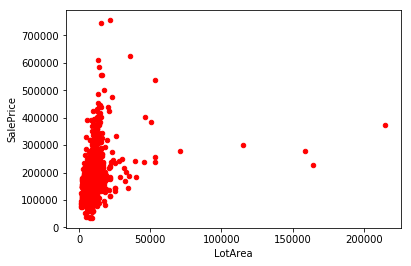

In [25]:
dataset.plot(kind = 'scatter', x='LotArea',y='SalePrice' , color = 'r')

We see that there are <b> outliers </b>. <br>
Even if there are only 4 outliers, it can hurt the standardisation process (as we substract by the mean). <br>
Therefore, the outliers were dropped by hand on these features.

## 1.5 Convert into inputs and labels

Now that we have pre-processed our data, we need to convert them into <b> inputs </b>  and <b> targets </b>.
<br>
<b> 'train.csv' </b> file is used as a training set (K-fold cross validation sets where taken from it) and <b> 'test.csv' </b> as a testing set.  

<br><br><br>

# 2. Model selection

Prima facie, the problem we are facing might seem to be problem well suited for linear regression techniques. Indeed, as the correlations indicate, the price of a house tends to rise with the living area, the size of the lot, the quality of the house and so on. Thus linear models were tried in the first place. 
<br>
Yet, since there are a lots of categorical features, ensemble techniques might have a role to play here, thus they were tried in the second place.



## 2.1 Metrics used

Two metrics are used to evaluate the models.
* The first one is a root-mean-square error between the log of the prediction and the log of the real value. It is the reference used to compare models between each other :

$$ rmse(Y,Y_{pred}) = \sqrt{mse( log(Y), log(Y_{pred}) )}   \quad $$


Nevertheless, we were not sure about 'good values' for this metric. So, we tried adding another metric that made more sense for us, to help have an idea of the scale of the metric.

* The second is mean of the relative errors, which should give more understandable values for humans, a kind of a tunned accuracy :

$$ tunned\_acc(Y,Y_{pred}) = \frac{1}{N} \sum_{k}^{N}  \frac{| y^{k} - y_{pred}^{k} | }{y^{k}}   \quad $$

To get the results we perform a coss-validation, so that we can compare the training score and validation score to make sure there is no overfitting.

## 2.2 Linear models

A simple linear regression was the first model to be tried. Yet, the model was very simple and might be too simple compared to the real model that links these features and the sale price of a house. 

Thus to make the model more complex and hence <b>reduce its bias</b>, polynomial features were added. Here, squarring the numerical features. The results are:

| Metric | Training set | Validation set |
|----------|----------|----------|
| log rmse error| 0.110081 | 0.156911 |
| tuned_acc |0.924130 | 0.898452 |

There is a quite important rise of the error between the test and the validation. This might be the sign of overfitting, our model might have too high variance. To reduce it and avoid overfitting, we try to use linear model with regularization such as Lasso and LassoCV (another version of lasso from sklearn that uses several regularization parameters). Lasso is a linear model trained with L1 prior as regularizer by minimizing $ \frac{ 1} {2 \times n_{samples}}  ||y - Xw||^{2}_{2} + \alpha ||w||_1$.

To find the best regularization parameter, cross-validation is performed several times with different parameters, then the plot of the validation error with respect to the parameters allows to choose the best one.

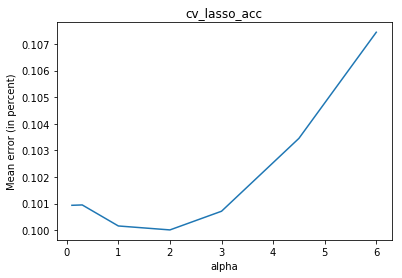

Text(0,0.5,'log rmse')

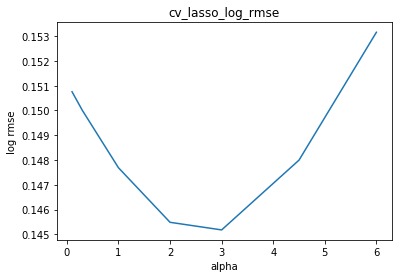

Here the best regularization parameter alpha for the reference metric (log rmse) is 3. Then the results of such a model are as follows :

| Metric | Training set | Validation set |
|----------|----------|----------|
| log rmse error| 0.113960 | 0.145177 |
| tuned_acc |0.919807 | 0.899289 |

The gap between training and testing error is still there but quite reduced, it indeed indicates that overfitting is limited thanks to regularization. Even if the training error is higher with regularization than without, the validation error is the other way around so the model with regularization is an improvement.

Other linear regression models with regularization were tried such as Ridge, Elastic Net but the results were not as good.

<b>NOTE :</b> &nbsp; As said in the introduction of this section, there are a lot of categorical features in the dataset. Their importance might be under represented in the linear regression models compared to numerical features. To better take the information they carry, we tried to compute new features multiplying a numerical feature by related categorical feature ordinaly encoded. For instance :
<br><b>LotFrontage_qual</b> = <b>LotFrontage * ExterQual</b> &emsp;  or &emsp;  <b>BsmtQual_SF</b> = <b>TotalBsmtSF * BsmtQual</b>
<br> Yet those new features added no improvement so they were not kept. Instead we switched to a totaly different type of model, ensemble models.

## 2.3 Ensemble models

After trying linear models, ensemble models should better take care of the categorical features, thus they are hopped to be well performing too. Random forest was first tried.

We tried to tuned the hyperparameters of the RandomForestRegressor. To do so, we used a gridsearch over few hyperparameters. <br>
A good thing with Random Forest is that it create 'n_estimators' decision trees of depth 'max_depth' and create a final regressor that takes into account all of these decision trees, which avoids the overfitting.


Here are the results after gridsearching for the best hyperparameters of the depth and number of estimators. 

{'random_state': 77, 'n_estimators': 10, 'max_depth': 5}
Feature ranking:
1. feature OverallQual (0.396008)
2. feature SQUARE LotArea (0.267115)
3. feature GrLivArea (0.168761)
4. feature TotalBsmtSF (0.049734)
5. feature BsmtFinSF1 (0.013681)


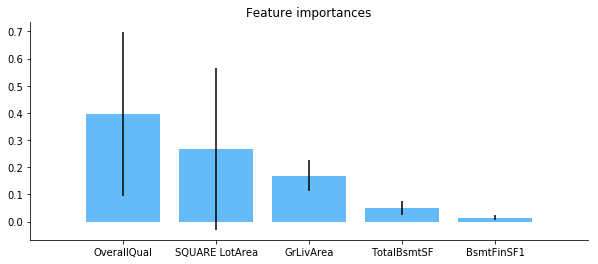

We see that compared of the Lasso best features, the <b> OverallQual </b> seems to be very important for this model.

Here are the results of training and testing errors with the tuned random forest :

| Metric | Training set | Validation set |
|----------|----------|----------|
| <b>log rmse error</b>| 0.144054 | 0.163958 |
|<b> tuned_acc </b>|0.905069 | 0.877626 |

SVM technique for regression has been tried but the results were not good enough for us to keep this solution.

## 2.4 Final selection 

With all the linear models and the random forest regressor, a choice should be made.
<br>
Therefore, the results were summurized as follows : 


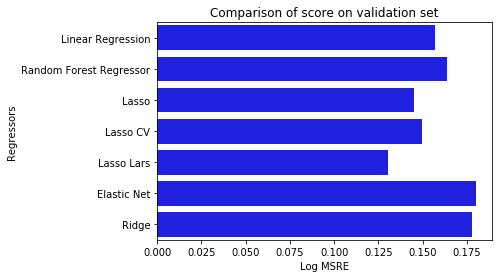

We decided to choose the Lasso linear regressor, which seems to have the best score for our metric (a score of <b> 0.145</b> )

<br>

# 3. Final prediction

Now that we have our final regressor, we can see how well it predicts our test set.

| Metric | Test set | 
|----------|----------|
| <b>log rmse error</b>| 0.134  | 
|<b> tuned_acc</b> |0.902  | 

It predicts as expected (we had a log rmse of 0.145 for the validation set, and here it predicts 0.134). The coefficient of the lasso model can be ploted to see which features are the most important in the model.

Text(0.5, 1.0, 'Coefficients in Lasso')

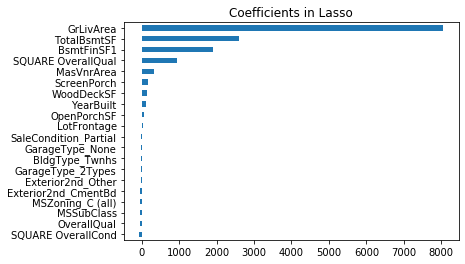

Above the 10 most important and the 10 least important. Without suprise and as expected, the <b> living area </b> is the most important feature, followed by the <b> size of the basement </b>, whether it is finished or not, the <b> overallquality squarred</b>.

<br>


# 4. Critics

We have some critics about our work.
<br>
Indeed, few things were made by an arbitrary choice and can be discussed : 
<br>

<ul>
    <li> How we handled the NaN values by making the mean
    <li> How we handled the outliers. Dropping them isn't a good solution. Indeed, when we tried to predict the dataset of kaggle, more than half of the dataset was dropped because of the outliers.
    <li> The number of the training set wasn't very large enough. We could have thought of way of increasing the number of inputs.
    
</ul>

A final comment on the complexity of the final model, Deep Learning models or other models with high   might improve the results since a linear regression is still a simple model in the end. Yet the lack of input data prevent this solution from being used. 


<b>Note</b> : We submitted our work in <b> Kaggle</b> and we got a score of <b>0.17</b> with random forest. The pre_processing was a little different because of the outliers discussed above, and so the results of the regressors were quite different too.